# Analyze RAGIS scalar timeseries

In [1]:
from datetime import datetime
import numpy as np
import pylab as plt
import xarray as xr
from glob import glob
import pandas as pd
import os
import re

import seaborn as sns

from pismragis.observations import load_imbie, load_mouginot
from pismragis.analysis import resample_ensemble_by_data, sensitivity_analysis
from pismragis.processing import convert_netcdf_to_dataframe, check_file, copy_file, ncfile2dataframe
from pismragis.stats import run_stats

In [2]:
n_jobs = 2
norm_year = 1992.0

plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

mass_varname = "SLE (cm)"
mass_uncertainty_varname = "SLE uncertainty (cm)"
discharge_varname = "D (Gt/yr)"
discharge_uncertainty_varname = "D uncertainty (Gt/yr)"
smb_varname = "SMB (Gt/yr)"
smb_uncertainty_varname = "SMB uncertainty (Gt/yr)"


bg_color = "#216779"
bg_color = "w"
sim_colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][1::]
imbie_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
sim_colors = ["#882255", "#AA4499", "#CC6677", "#DDCC77", "#88CCEE", "#44AA99", "#117733", "#332288"]
imbie_color = "k"
imbie_color = "#238b45"
mou_color = "#6a51a3"
    
kg2cmsle = 1 / 1e12 * 1.0 / 362.5 / 10.0
gt2cmsle = 1 / 362.5 / 10.0
sigma = 2

## Load IMBIE

In [3]:
# imbie = load_imbie(url="../imbie_dataset_greenland_dynamics-2020_02_28.xlsx")
imbie = load_imbie()
# Glacier and Ice cap bias 30 Gt/yr, add it back
imbie[mass_varname] -= 30 * gt2cmsle
imbie[smb_varname] += 30

In [4]:
mou = load_mouginot(url="/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pnas.1904242116.sd02.xlsx")

## Make a list of all experiments

In [5]:
data_dir = "/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pism/"

sims = {
    "CTRL": os.path.join(data_dir, "2023_08_ragis_tillwat/scalar/ts_gris_g900m_v2023_RAGIS_id_FM-0-VCM-0.45-S-0_1980-1-1_2020-1-1.nc"),
    "FM": os.path.join(data_dir, "2023_08_ragis_tillwat/scalar/ts_gris_g900m_v2023_RAGIS_id_FM-1-VCM-0.45-S-0_1980-1-1_2020-1-1.nc"),
}

# sims = {
#     "CTRL VCM-0.40": os.path.join(data_dir, "2023_08_ragis_tillwat/scalar/ts_gris_g900m_v2023_RAGIS_id_FM-0-VCM-0.40-S-0_1980-1-1_2020-1-1.nc"),
#     "CTRL VCM-0.41": os.path.join(data_dir, "2023_08_ragis_tillwat/scalar/ts_gris_g900m_v2023_RAGIS_id_FM-0-VCM-0.41-S-0_1980-1-1_2020-1-1.nc"),
#     "FM VCM-0.40": os.path.join(data_dir, "2023_08_ragis_tillwat/scalar/ts_gris_g900m_v2023_RAGIS_id_FM-1-VCM-0.40-S-0_1980-1-1_2020-1-1.nc"),
#     "FM VCM-0.45": os.path.join(data_dir, "2023_08_ragis_tillwat/scalar/ts_gris_g900m_v2023_RAGIS_id_FM-1-VCM-0.45-S-0_1980-1-1_2020-1-1.nc"),
# }

# sims = {
#     "RAGIS VCM-0.40": os.path.join(data_dir, "2023_08_ragis_tillwat/scalar/ts_gris_g900m_v2023_RAGIS_id_FM-0-VCM-0.40-S-0_1980-1-1_2020-1-1.nc"),
#     "RAGIS VCM-0.41": os.path.join(data_dir, "2023_08_ragis_tillwat/scalar/ts_gris_g900m_v2023_RAGIS_id_FM-0-VCM-0.41-S-0_1980-1-1_2020-1-1.nc"),
#     "RAGIS VCM-0.42": os.path.join(data_dir, "2023_08_ragis_tillwat/scalar/ts_gris_g900m_v2023_RAGIS_id_FM-0-VCM-0.42-S-0_1980-1-1_2020-1-1.nc"),
#     "RAGIS VCM-0.45": os.path.join(data_dir, "2023_08_ragis_tillwat/scalar/ts_gris_g900m_v2023_RAGIS_id_FM-0-VCM-0.45-S-0_1980-1-1_2020-1-1.nc"),
#     "GIMP VCM-0.41": os.path.join(data_dir, "2023_08_gimp_tillwat/scalar/ts_gris_g900m_v2023_GIMP_id_FM-0-VCM-0.41-S-0_1980-1-1_2020-1-1.nc"),
#     "GIMP VCM-0.42": os.path.join(data_dir, "2023_08_gimp_tillwat/scalar/ts_gris_g900m_v2023_GIMP_id_FM-0-VCM-0.42-S-0_1980-1-1_2020-1-1.nc"),
#     "GIMP VCM-0.45": os.path.join(data_dir, "2023_08_gimp_tillwat/scalar/ts_gris_g900m_v2023_GIMP_id_FM-0-VCM-0.45-S-0_1980-1-1_2020-1-1.nc"),
# }

# sims = {
#     "RAGIS VCM-0.40": os.path.join(data_dir, "2023_08_ragis_tillwat/scalar/ts_gris_g900m_v2023_RAGIS_id_FM-0-VCM-0.40-S-0_1980-1-1_2020-1-1.nc"),
#     "RAGIS VCM-0.405": os.path.join(data_dir, "2023_08_ragis_tillwat/scalar/ts_gris_g900m_v2023_RAGIS_id_FM-0-VCM-0.405-S-0_1980-1-1_2020-1-1.nc"),
#     "RAGIS VCM-0.41": os.path.join(data_dir, "2023_08_ragis_tillwat/scalar/ts_gris_g900m_v2023_RAGIS_id_FM-0-VCM-0.41-S-0_1980-1-1_2020-1-1.nc"),
#     "RAGIS VCM-0.42": os.path.join(data_dir, "2023_08_ragis_tillwat/scalar/ts_gris_g900m_v2023_RAGIS_id_FM-0-VCM-0.42-S-0_1980-1-1_2020-1-1.nc"),
#     "RAGIS VCM-0.45": os.path.join(data_dir, "2023_08_ragis_tillwat/scalar/ts_gris_g900m_v2023_RAGIS_id_FM-0-VCM-0.45-S-0_1980-1-1_2020-1-1.nc"),
#     "RAGIS VCM-0.75": os.path.join(data_dir, "2023_08_ragis_tillwat/scalar/ts_gris_g900m_v2023_RAGIS_id_FM-0-VCM-0.75-S-0_1980-1-1_2020-1-1.nc"),
# }

# sims = {
#     "GIMP": os.path.join(data_dir, "2023_08_gimp_tillwat/scalar/ts_gris_g900m_v2023_GIMP_id_FM-1-VCM-0.45-S-0_1980-1-1_2020-1-1.nc"),
#     "RAGIS": os.path.join(data_dir, "2023_08_ragis_tillwat/scalar/ts_gris_g900m_v2023_RAGIS_id_FM-1-VCM-0.45-S-0_1980-1-1_2020-1-1.nc"),
# }


## Process experiments

In [6]:


exp_dfs = []
for sim_key, sim_val in sims.items():
    if check_file(sim_val):
        df = ncfile2dataframe(sim_val, resample="yearly")
        exp_dfs.append(df)


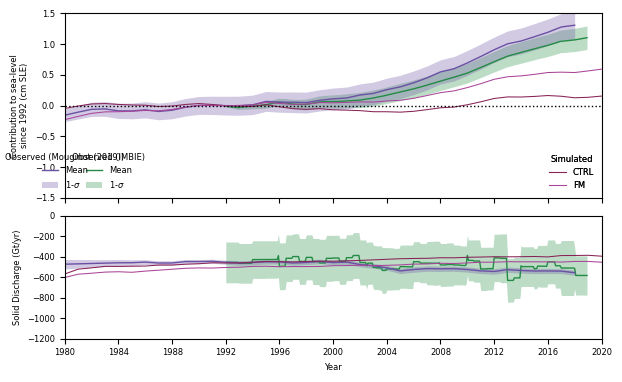

In [7]:
plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

fig, axs = plt.subplots(nrows=2, ncols=1, sharex="col", figsize=(6.2, 3.8), height_ratios=[3, 2])
fig.subplots_adjust(wspace=-0.5, hspace=-0.5)

for obs, o, obs_color, obs_loc  in zip([imbie, mou], ["IMBIE", "Mouginot (2019)"], 
                                       [imbie_color, mou_color], ["lower left", "lower center"]):
    obs_ci = axs[0].fill_between(obs["Date"], 
                    (obs[mass_varname] + sigma * obs[mass_uncertainty_varname]), 
                    (obs[mass_varname] - sigma * obs[mass_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=0.30, label="1-$\sigma$")
    axs[1].fill_between(obs["Date"], 
                    (obs[discharge_varname] + sigma * obs[discharge_uncertainty_varname]), 
                    (obs[discharge_varname] - sigma * obs[discharge_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=0.30)
    obs_line = axs[0].plot(obs["Date"], obs[mass_varname], color=obs_color, lw=1, label="Mean")
    axs[1].plot(obs["Date"], obs[discharge_varname], color=obs_color, lw=1)

    legend_obs = axs[0].legend(handles=[obs_line[0], obs_ci], loc=obs_loc, bbox_to_anchor=(0.0, 0.0), 
                               title=f"Observed ({o})")
    legend_obs.get_frame().set_linewidth(0.0)
    legend_obs.get_frame().set_alpha(0.0)
    axs[0].add_artist(legend_obs)


sim_handles = []
sim_labels = []
for k, exp in enumerate(exp_dfs):
    sim_label = list(sims.keys())[k]
    sim_handle = axs[0].plot(exp["time"], exp[mass_varname], color=sim_colors[k], alpha=1.0, lw=0.75)
    axs[1].plot(exp["time"], exp[discharge_varname], color=sim_colors[k], alpha=1.0, lw=0.75)
    sim_handles.append(sim_handle[0])
    sim_labels.append(sim_label)


fig.set_facecolor(bg_color)
for ax in axs:
    ax.set_facecolor(bg_color)
fig.set_facecolor(bg_color)

axs[0].axhline(0, color="k", ls="dotted", lw=1.0)
axs[0].set_xlabel("")
axs[0].set_ylabel("Contribution to sea-level\nsince 1992 (cm SLE)")
axs[-1].set_xlabel("Year")
axs[1].set_ylabel("Solid Discharge (Gt/yr)")
axs[0].set_xlim(pd.to_datetime("1980-1-1"), pd.to_datetime("2020-1-1"))
axs[0].set_ylim(-1.5, 1.5)
axs[1].set_ylim(-1200, 0)


legend_sim = axs[0].legend(handles=sim_handles, labels=sim_labels, loc="lower right", ncols=1, title="Simulated")
legend_sim.get_frame().set_linewidth(0.0)
legend_sim.get_frame().set_alpha(0.0)
axs[0].add_artist(legend_sim)

fig.tight_layout()
fig.savefig("ragis-comp_scalar.pdf")
!open ragis-comp_scalar.pdf